In [1]:
from PIL import Image
import os
import glob
import numpy as np

In [2]:
def crop_and_encode(dirname):
    for basename in os.listdir(dirname):
        path = os.path.join(dirname, basename)
        image = Image.open(path)

        top_left = np.random.uniform(low=0.01, high=0.7, size=2)
        
        # don't let crops be less than this fraction of the original image's height or width
        min_fraction = 0.2
        bottom_right = np.random.uniform(low=top_left + min_fraction, high=0.99)

        size_px = np.array(image.size)
        top_left_px = (size_px * top_left).astype(np.int32)
        bottom_right_px = (size_px * bottom_right).astype(np.int32)

        filename = os.path.splitext(basename)[0]

        box = (*top_left_px, *bottom_right_px)
        print(size_px, box)
        cropped_image = image.crop(box)
        print(path)
        for quality in (5, 10, 20, 75):
            cropped_filename = f'{filename}_{top_left_px[0]:04d}_{top_left_px[1]:04d}_q{quality:02d}'
            print(f"    -> {cropped_filename}")
            save_path = os.path.join(dirname, f'{cropped_filename}.jpg')
            cropped_image.save(save_path, quality=quality)

In [32]:
dirname = 'images'
# crop_and_encode(dirname)

In [4]:
original = Image.open('data/dogscats/sample/test1/10001.jpg')
crop = Image.open('data/dogscats/sample/test1/10001_0333_0032_q20.jpg')

In [5]:
original = Image.open('data/dogscats/sample/test1/10003.jpg')
crop = Image.open('data/dogscats/sample/test1/10003_0151_0042_q05.jpg')

In [6]:
original = Image.open('data/dogscats/sample/test1/10002.jpg')
crop = Image.open('data/dogscats/sample/test1/10002_0301_0170_q75.jpg')
not_original = Image.open('data/dogscats/sample/test1/10003.jpg')
not_crop = Image.open('data/dogscats/sample/test1/10003_0151_0042_q05.jpg')

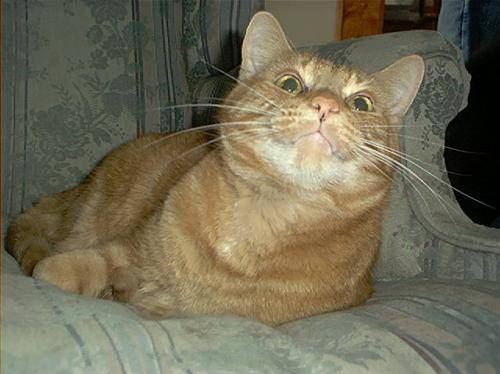

In [7]:
scale = 1.0
original = original.resize((int(original.size[0]*scale), int(original.size[1]*scale)))
original

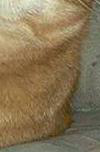

In [8]:
crop = crop.resize((int(crop.size[0]*scale), int(crop.size[1]*scale)))
crop

In [9]:
from matplotlib import pyplot as plt
def plot(x):
    # imshow wants (h, w, channels), torch uses (channels, h, w)
    i = x.permute((1,2,0))
    plt.imshow(i)

In [10]:
from torchvision import transforms
original_tensor = transforms.ToTensor()(original)
crop_tensor = transforms.ToTensor()(crop)

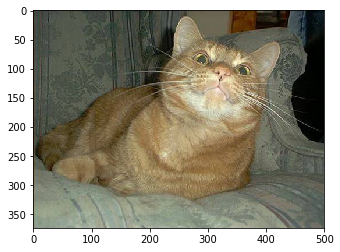

In [11]:
plot(original_tensor)

In [12]:
import torch
from torch.nn import functional as F

o = original_tensor[None]
w = crop_tensor[None]
nw = torch.ones(w.shape)
b = torch.Tensor([1.0])

o.requires_grad = False
w.requires_grad = False
nw.requires_grad = False
b.requires_grad = False

if torch.cuda.is_available():
    o.cuda()
    w.cuda()
    nw.cuda()
    b.cuda()
    
conv = F.conv2d(o, w, bias=b, stride=1, padding=0, dilation=(1,1) , groups=1)
norm = F.conv2d(o, nw, bias=b, stride=1, padding=0, dilation=(1,1) , groups=1)

In [13]:
def plot_single_channel(x):
    # imshow wants (h, w, channels), torch uses (channels, h, w)
    plt.imshow(x[0, 0], cmap='gray')

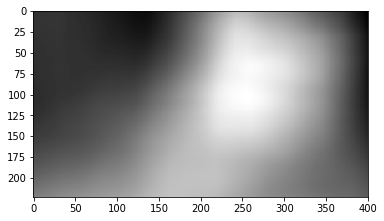

In [14]:
plot_single_channel(conv)

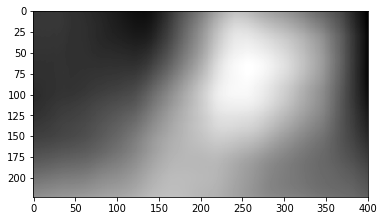

In [15]:
plot_single_channel(norm)

In [16]:
normalized_conv = torch.log(conv) / torch.log(norm)
# normalized_conv = conv / norm

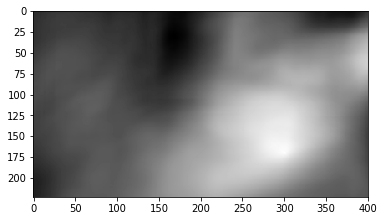

In [17]:
plot_single_channel(normalized_conv)

### projection plots

Let's look at the sum of all of the columns in one plot, then the sum of all of the rows in another.

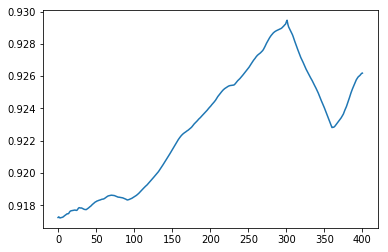

In [18]:
plt.plot(normalized_conv.squeeze().data.numpy().max(axis=0));

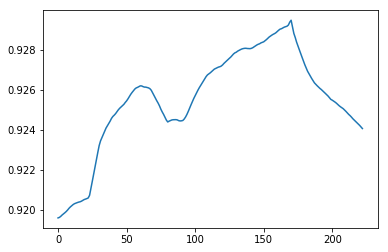

In [19]:
plt.plot(normalized_conv.squeeze().data.numpy().max(axis=1));

In [20]:
x = normalized_conv
pt = x.squeeze().data.numpy().argmax()
loc = int((pt % x.shape[-1])/scale), int((pt // x.shape[-1])/scale)
loc

(301, 170)

### crosshair plot

Let's look at the value of the normalized convolution for x values with y held fixed at y_max, and for y values with x held fixed at x_max.

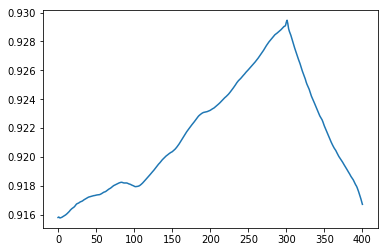

In [21]:
plt.plot(x.squeeze().data.numpy()[loc[1], :]);

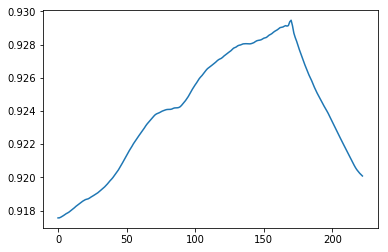

In [22]:
plt.plot(x.squeeze().data.numpy()[:, loc[0]]);

In [23]:
def get_normalized_conv(target, kernel, lognorm=True):
    t = target[None]
    k = kernel[None]
    nk = torch.ones(k.shape)
    b = torch.Tensor([1.0])

    t.requires_grad = False
    k.requires_grad = False
    nk.requires_grad = False
    b.requires_grad = False

    if torch.cuda.is_available():
        t.cuda()
        k.cuda()
        nk.cuda()
        b.cuda()

    conv = F.conv2d(t, k, bias=b, stride=1, padding=0, dilation=(1,1) , groups=1)
    norm = F.conv2d(t, nk, bias=b, stride=1, padding=0, dilation=(1,1) , groups=1)
    
    return torch.log(conv) / torch.log(norm)

def get_max_coords(tensor, scale=1.0):
    pt = tensor.squeeze().data.numpy().argmax()
    loc = int((pt % tensor.shape[-1])/scale), int((pt // tensor.shape[-1])/scale)
    return loc

def get_original_and_crop(first, second):
    first_size = first.size[0] * first.size[1]
    second_size = second.size[0] * second.size[1]
    
    if first_size > second_size:
        original = first
        crop = second
    else:
        original = second
        crop = first
        
    return original, crop
    
def predict_crop_coords(first_image, second_image, scale=1.0):
    original, crop = get_original_and_crop(first_image, second_image)
        
    original = original.resize((int(original.size[0]*scale), int(original.size[1]*scale)))
    crop = crop.resize((int(crop.size[0]*scale), int(crop.size[1]*scale)))
    
    original_tensor = transforms.ToTensor()(original)
    crop_tensor = transforms.ToTensor()(crop)
    
    normalized_conv = get_normalized_conv(original_tensor, crop_tensor)
    return get_max_coords(normalized_conv, scale=scale)

In [24]:
# paired
original = Image.open('data/dogscats/sample/test1/10002.jpg')
crop = Image.open('data/dogscats/sample/test1/10002_0301_0170_q75.jpg')

import time

for scale in np.linspace(0.05, 1.0, 20):
    t1 = time.time()
    loc = predict_crop_coords(crop, original, scale=scale)
    err = (abs(loc[0] - 301), abs(loc[1] - 170))
    t2 = time.time()
    total_time_ms = (t2 - t1) * 1000
    print(f"Scale: {scale:2.2f}, loc: {loc}, err: {err}, time: {total_time_ms:3.1f} ms")

Scale: 0.05, loc: (280, 140), err: (21, 30), time: 49.5 ms
Scale: 0.10, loc: (280, 140), err: (21, 30), time: 119.6 ms
Scale: 0.15, loc: (286, 160), err: (15, 10), time: 78.7 ms
Scale: 0.20, loc: (300, 165), err: (1, 5), time: 35.6 ms
Scale: 0.25, loc: (300, 168), err: (1, 2), time: 152.8 ms
Scale: 0.30, loc: (300, 170), err: (1, 0), time: 209.3 ms
Scale: 0.35, loc: (300, 168), err: (1, 2), time: 243.3 ms
Scale: 0.40, loc: (297, 167), err: (4, 3), time: 373.4 ms
Scale: 0.45, loc: (300, 168), err: (1, 2), time: 415.4 ms
Scale: 0.50, loc: (300, 170), err: (1, 0), time: 546.0 ms
Scale: 0.55, loc: (300, 169), err: (1, 1), time: 853.8 ms
Scale: 0.60, loc: (300, 168), err: (1, 2), time: 1086.5 ms
Scale: 0.65, loc: (300, 169), err: (1, 1), time: 1488.4 ms
Scale: 0.70, loc: (300, 168), err: (1, 2), time: 2115.6 ms
Scale: 0.75, loc: (301, 169), err: (0, 1), time: 3143.6 ms
Scale: 0.80, loc: (300, 170), err: (1, 0), time: 3568.8 ms
Scale: 0.85, loc: (301, 169), err: (0, 1), time: 4290.5 ms
Scale

In [25]:
# unpaired

original = Image.open('data/dogscats/sample/test1/10002.jpg')
crop = Image.open('data/dogscats/sample/test1/10003_0151_0042_q05.jpg')

for scale in np.linspace(0.05, 1.0, 20):
    t1 = time.time()
    loc = predict_crop_coords(crop, original, scale=scale)
    t2 = time.time()
    total_time_ms = (t2 - t1) * 1000
    print(f"Scale: {scale:2.2f}, loc: {loc}, time: {total_time_ms:3.1f} ms")

Scale: 0.05, loc: (240, 140), time: 4.2 ms
Scale: 0.10, loc: (210, 130), time: 1.0 ms
Scale: 0.15, loc: (226, 140), time: 48.3 ms
Scale: 0.20, loc: (220, 135), time: 61.6 ms
Scale: 0.25, loc: (244, 148), time: 128.7 ms
Scale: 0.30, loc: (250, 146), time: 161.8 ms
Scale: 0.35, loc: (228, 148), time: 173.0 ms
Scale: 0.40, loc: (250, 147), time: 307.2 ms
Scale: 0.45, loc: (246, 151), time: 525.8 ms
Scale: 0.50, loc: (244, 148), time: 709.8 ms
Scale: 0.55, loc: (249, 149), time: 972.3 ms
Scale: 0.60, loc: (246, 148), time: 1295.0 ms
Scale: 0.65, loc: (253, 149), time: 2119.3 ms
Scale: 0.70, loc: (250, 148), time: 2804.8 ms
Scale: 0.75, loc: (246, 150), time: 3503.4 ms
Scale: 0.80, loc: (250, 148), time: 5052.6 ms
Scale: 0.85, loc: (250, 148), time: 6756.3 ms
Scale: 0.90, loc: (251, 148), time: 7494.5 ms
Scale: 0.95, loc: (250, 149), time: 10545.2 ms
Scale: 1.00, loc: (251, 149), time: 13698.7 ms


In [26]:
import copy

def get_idx(t, w, h):
    idx = (slice(None), slice(h, h+t.size(1)), slice(w, w+t.size(2)))
    return idx

def _subtract(t1, t2, idx):
    t3 = copy.deepcopy(t1)
    t3[idx] -= t2
    return t3.abs()

def subtract(t1, t2, w, h):
    idx = get_idx(t2, w, h)
    return _subtract(t1, t2, idx)

def _get_mad(t1, t2, idx):
    return (t1[idx] - t2).abs().mean()

def get_mad(t1, t2, w, h):
    idx = get_idx(t2, w, h)
    return _get_mad(t1, t2, idx)

def get_mad_images(first, second, loc):
    w, h = loc
    original, crop = get_original_and_crop(first, second)
    
    t1 = transforms.ToTensor()(original)
    t2 = transforms.ToTensor()(crop)
    
    idx = get_idx(t2, w, h)
    return _get_mad(t1, t2, idx)

In [27]:
def visualize(first, second, loc):
    w, h = loc
    print(f'Coords: {loc}')
    original, crop = get_original_and_crop(first, second)
    
    t1 = transforms.ToTensor()(original)
    t2 = transforms.ToTensor()(crop)
    
    idx = get_idx(t2, w, h)
    s = _subtract(t1, t2, idx)
    s[idx] *= 1
    plot(s)
    
    score = get_mad(t1, t2, w, h).data.numpy()
    print(f'Mean Absolute Difference: {score:3.4f}')

### Determine threshold for pair detection

If we predict the coordinates, and then subtract the crop from the original, we the resulting patch should be close to zeros.  How close? well lets try it out and see if we can just put a simple threshold between crop pairs and non-pairs.

Coords: (151, 42)
Mean Absolute Difference: 0.0598
Coords: (301, 170)
Mean Absolute Difference: 0.0130


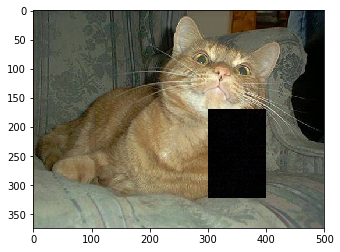

In [28]:
original = Image.open('data/dogscats/sample/test1/10002.jpg')
crop = Image.open('data/dogscats/sample/test1/10002_0301_0170_q75.jpg')
not_original = Image.open('data/dogscats/sample/test1/10003.jpg')
not_crop = Image.open('data/dogscats/sample/test1/10003_0151_0042_q05.jpg')

visualize(not_crop, not_original, (151,42))
visualize(crop, original, (301, 170))

Coords: (80, 40)
Mean Absolute Difference: 0.2826
Coords: (246, 148)
Mean Absolute Difference: 0.2870


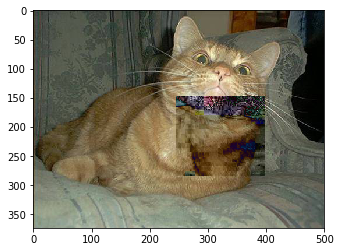

In [29]:
visualize(crop, not_original, predict_crop_coords(not_original, crop, scale=0.50))
visualize(not_crop, original, predict_crop_coords(original, not_crop, scale=0.50))

### fine-tune the predictions

The predictions from analyzing the convolutions might be off by a few pixels... Lets look at neighbors and compare their mean average difference (mad) values.

In [30]:
original = Image.open('data/dogscats/sample/test1/10002.jpg')
crop = Image.open('data/dogscats/sample/test1/10002_0301_0170_q75.jpg')

predicted_loc = predict_crop_coords(original, crop, scale=0.3)
print(f"predicted_loc: {predicted_loc}")

best_mad = get_mad_images(original, crop, predicted_loc)
best_loc = predicted_loc
for i in range(-3, 4):
    for j in range(-3, 4):
        loc = (predicted_loc[0] + i, predicted_loc[1] + j)
        mad = get_mad_images(original, crop, loc)
        if mad < best_mad:
            best_loc = loc
            best_mad = mad
            print(f"loc: {loc}, mad: {mad:3.4f}  <---<< (new best)")
        else:
            print(f"loc: {loc}, mad: {mad:3.4f}")

predicted_loc: (300, 170)
loc: (297, 167), mad: 0.0508
loc: (297, 168), mad: 0.0474
loc: (297, 169), mad: 0.0443
loc: (297, 170), mad: 0.0418
loc: (297, 171), mad: 0.0410
loc: (297, 172), mad: 0.0424
loc: (297, 173), mad: 0.0447
loc: (298, 167), mad: 0.0485
loc: (298, 168), mad: 0.0442
loc: (298, 169), mad: 0.0413
loc: (298, 170), mad: 0.0397
loc: (298, 171), mad: 0.0395
loc: (298, 172), mad: 0.0407
loc: (298, 173), mad: 0.0428
loc: (299, 167), mad: 0.0463
loc: (299, 168), mad: 0.0413
loc: (299, 169), mad: 0.0370
loc: (299, 170), mad: 0.0356
loc: (299, 171), mad: 0.0382
loc: (299, 172), mad: 0.0405
loc: (299, 173), mad: 0.0421
loc: (300, 167), mad: 0.0450
loc: (300, 168), mad: 0.0392
loc: (300, 169), mad: 0.0296
loc: (300, 170), mad: 0.0244
loc: (300, 171), mad: 0.0325
loc: (300, 172), mad: 0.0399
loc: (300, 173), mad: 0.0428
loc: (301, 167), mad: 0.0442
loc: (301, 168), mad: 0.0391
loc: (301, 169), mad: 0.0260
loc: (301, 170), mad: 0.0130  <---<< (new best)
loc: (301, 171), mad: 0.025